        Data Fields

**[] fullVisitorId**- A unique identifier for each user of the Google Merchandise Store.

**[x] channelGrouping** - The channel via which the user came to the Store. 

**[] date** - The date on which the user visited the Store.

**[x] device** - The specifications for the device used to access the Store.

**[x] geoNetwork** - This section contains information about the geography of the user.

**[] sessionId** - A unique identifier for this visit to the store.

**[x] socialEngagementType** - Engagement type, either "Socially Engaged" or "Not Socially Engaged".

**[x] totals** - This section contains aggregate values across the session.

**[x] trafficSource** - This section contains information about the Traffic Source from which the session originated.

**[] visitId** - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.

**[] visitNumber** - The session number for this user. If this is the first session, then this is set to 1.

**[] visitStartTime** - The timestamp (expressed as POSIX time).

In [88]:
import pandas as pd
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

In [89]:
def load_df(csv_path='../input/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

print(os.listdir("../input"))

['train.csv', 'sample_submission.csv', 'test.csv']


In [90]:
%%time
train_df = load_df()
test_df = load_df("../input/test.csv")
train_df.head(10)
# df_small = load_df(nrows=20000)

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)
Loaded train.csv. Shape: (20000, 54)
CPU times: user 4min 59s, sys: 4.07 s, total: 5min 3s
Wall time: 5min 3s


In [91]:
train_origin = train_df.copy()
test_origin = test_df.copy()

**Remove target from traning set**

The target we want to predict, transactionRevenue, is contained in one of the JSON columns, ie. the totals column. While loading the dataset, it was renamed as totals.transactionRevenue. The target only contains a few non-null values and before taking its log, we fill the NAs:

In [92]:
target = train_df['totals.transactionRevenue'].fillna(0).astype(float)
target = target.apply(lambda x: np.log1p(x))
if 'totals.transactionRevenue' in train_df.columns:
    del train_df['totals.transactionRevenue']

In [93]:
# Remove targe from tesint
if 'totals.transactionRevenue' in test_df.columns:
    del test_df['totals.transactionRevenue']

**Distribution of target**

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


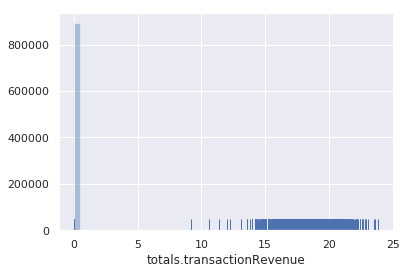

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set(color_codes=True)
sns.distplot(target, kde=False, rug=True);

**Show columns of dataset**

In [95]:
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserSize', 'device.browserVersion',
       'device.deviceCategory', 'device.flashVersion', 'device.isMobile',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews', 'totals.visits',
       'trafficS

In [96]:
test_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserSize', 'device.browserVersion',
       'device.deviceCategory', 'device.flashVersion', 'device.isMobile',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews', 'totals.visits',
       'trafficS

**Add date feature**

In [97]:
for df in [train_df, test_df]:
    df['date'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['sess_date_dow'] = df['date'].dt.dayofweek
    df['sess_date_hours'] = df['date'].dt.hour
    df['sess_date_dom'] = df['date'].dt.day

In [114]:
train_df = train_origin.copy()
test_df = test_origin.copy()
for df in [train_df, test_df]:
    df['date'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['sess_date_dow'] = df['date'].dt.dayofweek
    df['sess_date_hours'] = df['date'].dt.hour
    df['sess_date_dom'] = df['date'].dt.day

In [116]:
train_df.columns.shape, test_df.columns.shape, train_origin.columns.shape, test_origin.columns.shape

((58,), (56,), (55,), (53,))

In [117]:
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserSize', 'device.browserVersion',
       'device.deviceCategory', 'device.flashVersion', 'device.isMobile',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.transactionRevenue

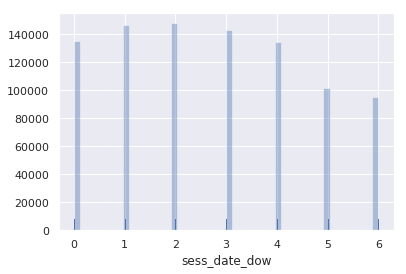

In [99]:
sns.set(color_codes=True)
# distribution by day of week
sns.distplot(train_df['sess_date_dow'], kde=False, rug=True);

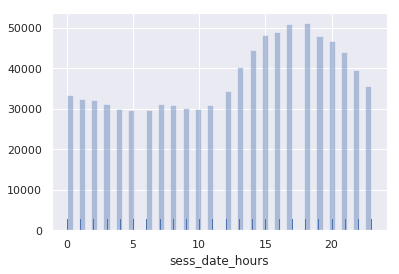

In [100]:
# distribution by hour of day
sns.distplot(train_df['sess_date_hours'], kde=False, rug=True);

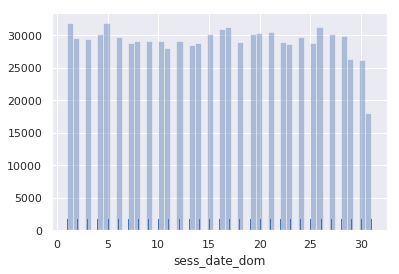

In [101]:
# distribution by day of month
sns.distplot(train_df['sess_date_dom'], kde=False, rug=True);

**Create feature list**

In [119]:
excluded_features = [
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime'
]

categorical_features = [
    _f for _f in train_df.columns
    if (_f not in excluded_features) # & (train_df[_f].dtype == 'object')
]
print("Number of selected features : ",len(categorical_features))


Number of selected features :  52


In [120]:
categorical_features

['channelGrouping',
 'socialEngagementType',
 'visitNumber',
 'device.browser',
 'device.browserSize',
 'device.browserVersion',
 'device.deviceCategory',
 'device.flashVersion',
 'device.isMobile',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystem',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.city',
 'geoNetwork.cityId',
 'geoNetwork.continent',
 'geoNetwork.country',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.metro',
 'geoNetwork.networkDomain',
 'geoNetwork.networkLocation',
 'geoNetwork.region',
 'geoNetwork.subContinent',
 'totals.bounces',
 'totals.hits',
 'totals.newVisits',
 'totals.pageviews',
 'totals.visits',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'trafficSource

In [121]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 58 columns):
channelGrouping                                      903653 non-null object
date                                                 903653 non-null datetime64[ns]
fullVisitorId                                        903653 non-null object
sessionId                                            903653 non-null object
socialEngagementType                                 903653 non-null object
visitId                                              903653 non-null int64
visitNumber                                          903653 non-null int64
visitStartTime                                       903653 non-null int64
device.browser                                       903653 non-null object
device.browserSize                                   903653 non-null object
device.browserVersion                                903653 non-null object
device.deviceCategory                           

In [122]:
columns_to_remove = [col for col in train_df.columns if train_df[col].nunique() == 1]
print("Nb. of variables with unique value: {}".format(len(columns_to_remove)))

Nb. of variables with unique value: 24


In [123]:
for col in columns_to_remove:
    if set(['not available in demo dataset']) ==  set(train_df[col].unique()): continue
    print(col, train_df[col].dtypes, train_df[col].unique())

socialEngagementType object ['Not Socially Engaged']
totals.bounces object ['1' nan]
totals.newVisits object ['1' nan]
totals.visits object ['1']
trafficSource.adwordsClickInfo.isVideoAd object [nan False]
trafficSource.campaignCode object [nan '11251kjhkvahf']
trafficSource.isTrueDirect object [nan True]


In [124]:
train_df.shape, test_df.shape

((903653, 58), (804684, 56))

In [125]:
# columns = [col for col in train_df.columns if train_df[col].nunique() > 1 and (col in categorical_features)]
columns2 = [col for col in test_df.columns if  test_df[col].nunique() > 1 and (col in categorical_features)]

train_df = train_df[columns2]
test_df = test_df[columns2]
print(train_df.shape, test_df.shape)

(903653, 28) (804684, 28)


In [126]:
train_df.columns

Index(['channelGrouping', 'visitNumber', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.hits', 'totals.pageviews',
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.keyword', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.source', 'sess_date_dow',
       'sess_date_hours', 'sess_date_dom'],
      dtype='object')

In [127]:
test_df.columns

Index(['channelGrouping', 'visitNumber', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.hits', 'totals.pageviews',
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.keyword', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.source', 'sess_date_dow',
       'sess_date_hours', 'sess_date_dom'],
      dtype='object')

**DONE for select feature and factorizing dataset**

In [128]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 28 columns):
channelGrouping                                 903653 non-null object
visitNumber                                     903653 non-null int64
device.browser                                  903653 non-null object
device.deviceCategory                           903653 non-null object
device.isMobile                                 903653 non-null bool
device.operatingSystem                          903653 non-null object
geoNetwork.city                                 903653 non-null object
geoNetwork.continent                            903653 non-null object
geoNetwork.country                              903653 non-null object
geoNetwork.metro                                903653 non-null object
geoNetwork.networkDomain                        903653 non-null object
geoNetwork.region                               903653 non-null object
geoNetwork.subContinent                 

In [130]:
train_df['geoNetwork.continent'].value_counts()

Americas     450377
Asia         223698
Europe       198311
Oceania       15054
Africa        14745
(not set)      1468
Name: geoNetwork.continent, dtype: int64